In [65]:
from IPython.display import Image

### IBM Advanced Data Science Capstone Project
#### Salvatore Salpietro

<hr/>

###### Purpose

The scope pf this project is to build a classifier to detect diseased lung from chest x-ray images, where the diease is pneumonia.

###### What is pneumonia

Pneumonia is an inflammatory lung disease that affects the small air sacs called alvioli.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/images/pneumonia.jpg" width=350 />

###### Types
There are three main classification of pneumonia by location in the lungs, these are,

- Lobar and Multilobar pneumonia is an infection that involves one or more lobes, or section, of a lung. Lobar pneumonia is often due to Streptococcus pneumoniae (though Klebsiella pneumoniae is also possible.) Multilobar pneumonia involves more than one lobe, and it often causes a more severe illness.
- Bronchial pneumonia affects the lungs in patches around the tubes (bronchi or bronchioles).
- Interstitial pneumonia involves the areas in between the alveoli, and it may be called "interstitial pneumonitis." It is more likely to be caused by viruses or by atypical bacteria.

<img src="https://github.com/erotavlas/machine-learning/raw/main/images/types-of-pneumonia.jpeg" width=350 />

###### Symptoms
People with this condition typically exhibit the following symptoms of variable severity 
- cough 
- chest pain 
- fever 
- difficulty breathing. 

###### Causes
The causes are mainly due to viruses and bacteris but can also be from fungii, parasites or noninfectious causes.  

<img src="https://github.com/erotavlas/machine-learning/raw/main/images/causes.jpg" width=500>

###### Diagnosis
In order to verify a case of pneumonia in a patient, doctors rely on a combination of methods including observing physical signs, blood tests, and often a chest X-ray.  The chest X-ray is useful not only for diagnosis, but also to determine the extent of disease in the lungs.  

###### How does a doctor determine if a lung is diseased or not from chest X-rays?  
A chest X-ray is a radiology test that involves exposing the chest briefly to radiation to produce an image of the chest and the internal organs of the chest. An X-ray film is positioned against the body opposite the camera, which sends out a very small dose of a radiation beam. As the radiation penetrates the body, it is absorbed in varying amounts by different body tissues depending on the tissue's composition of air, water, blood, bone, or muscle. The X-ray image records these difference in penetration of the X-ray beam to produce an image of body tissue structures. The white shadows on chest X-ray represent areas where the beam is blocked by more dense or solid tissues, such as bone or heart.  The darker shadows on the chest X-ray represent areas where the x-ray beam penetrates more easily such as in air filled tissues like the lungs. 

Here is an example of chest x-rays for normal lung vs lung affected by pneumonia.
<img src="https://github.com/erotavlas/machine-learning/raw/main/images/normal_vs_pneumonia.png" width=500 />

Doctors look for lighter areas in the lung indicating the precense of inflammation and fluid buildup.  This causes areas of the lung to become lighter on the x-ray image compared to the darker air filled areas of healthy lungs.

###### Can AI assist in this process?
In this project we will attempt to create a machine learning model that will effectively replace what the doctor is doing when they screen a patient for lung disease, in this case the disease is pneumonia.  By training the model on a set of healthy and diseased lung X-ray images, it will learn to distinguish between the two types.  The end result will be a model that reproduces what a doctor does to determine if the patient x-ray indicates pneumonia or not.

### Importing libraries

In [1]:
from skimage import io # allows to read images
from matplotlib import pyplot
from pathlib import Path
from natsort import natsorted, ns # natural sorting

import pandas as pd
import statistics
import random
import os
import seaborn as sns

### Data analysis step

Determine the characteristics of the data and statistics 

#### 1. Data source

Data was obtained from the following source 
https://data.mendeley.com/datasets/rscbjbr9sj/3

We are provided with an archive file containing a set of chest x-rays.  Images are provided in two separate folders, test and train.  Within those folders images are separated into two classes - normal and pneumonia.  

#### 2. Characteristics of files

In [2]:
sizes = [] # sizes in kb
all_extensions = set([])
filenum = []
count = 0

test_images = []
test_labels = []

train_images = []
train_labels = []

#training set
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\train"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)
        
        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000) 
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        train_images.append(os.path.join(root, name))
        train_labels.append(os.path.basename(root))
        
        filenum.append(count)

#test set
for root, dirs, files in os.walk("E:\COURSES\Advanced Data Science With IBM\Advanced Data Science Capstone\\assignment\data\chest_xray\\test"):
    #print('dirs', dirs)
    for name in files:
        #print('name', name)
        #print(os.path.basename(root))
        
        file_name, file_extension = os.path.splitext(name)
        all_extensions.add(file_extension)

        stats = os.stat(os.path.join(root, name))
        count = count + 1
        
        sizes.append(stats.st_size/1000)
        
        #if(stats.st_size/1000 < 12):
        #    discarded.append(os.path.join(root, name))
        #else:
        test_images.append(os.path.join(root, name))
        test_labels.append(os.path.basename(root))
        
        filenum.append(count)

##### 2.1. File names

File names for images of dieases lungs contain a unique anonymized person number as well as the text 'bacteris' or 'virus' indicating if the pnemonia was caused by a virus or bacteris.  Example person426_virus_873

File names for images of normal lungs contain the work 'NORMAL'. Example - NORMAL2-IM-1250-0001

##### 2.2. File extensions

In [3]:
print(all_extensions)

{'.jpeg'}


Files are all the same type - jpeg

##### 2.3. Total number of image files

In [4]:
total_image_files = len(train_images) + len(test_images)

In [5]:
print(total_image_files)

5856


There are a total of 5856 files across both folders (test and train)

##### 2.4. Distribution of image files in test and train folders

In [6]:
len(test_images)

624

In [7]:
len(train_images)

5232

Train / Test split is about 89.4 / 10.6. 

##### 2.5 Class distribution

In [8]:
pneumonia = [i for i in train_labels if i == 'PNEUMONIA']
normal = [i for i in train_labels if i == 'NORMAL']

In [9]:
len(normal)

1349

In [10]:
len(pneumonia)

3883

In [11]:
print('There are ', len(pneumonia)/len(normal), ' more pneumonia images than normal images')

There are  2.878428465530022  more pneumonia images than normal images


#### 4. Size of the images

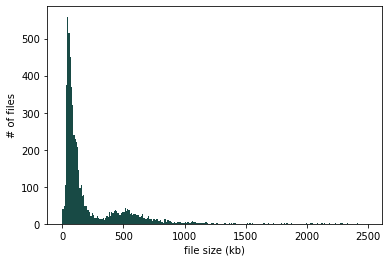

In [12]:
import matplotlib.pyplot as plt

b = [i for i in range(0,2500,10)]

plt.xlabel('file size (kb)')
plt.ylabel('# of files')
plt.hist(sizes, bins=b,  color='#184A45FF')
plt.show()

Above is a histogram plot to show the ditribution of file sizes.  Most of the files are of size less than 1000 kb.

In [13]:
avg = sum(sizes)/len(sizes)
print(avg)

211.14802015027237


In [14]:
print(statistics.median(sizes))

95.839


In [15]:
print(min(sizes))

5.441


In [16]:
print(max(sizes))

2414.342


The mean file size is 211.148

The median file size is 95.839

The minimum file size observed is 5.441 kb

The maximum file size observed is 2412.342 kb

Sonce the file sizes are not all the same, some examination of the really small ans really large image files revealed that the really small images aspect ratio did not match those of the majority of images (i.e. they were longer in width than height and did not reveal the full chest/lung view).  These images might be considered outliers.  Further examination of the images below will attempt to exclude such outliers.  

#### 4. Aspect ratio of the images

The aspect ratio of an image is the ratio of its width to its height.
The formula is width / height.

Not all the images are of the same aspect ratio. On examining some of the images of smaller size, some did not show the full view of the chest and lungs.  We will remove these images.

If the shape of the image is longer in the x axis than it is in the y axis by certain threshold, then discard those images as they only show a section of the full chest image.

Choose something x/y must be less than or equal to 2 to constitute an acceptible image. (i.e. if the width is two or more times longer than the height then discard image)

In [17]:
temp_train_images = []
temp_train_labels = []

temp_test_images = []
temp_test_labels = []

discarded = []

for i in range(len(train_images)):
    xray = io.imread(train_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_train_images.append(train_images[i])
        temp_train_labels.append(train_labels[i])
    else:
        discarded.append(train_images[i])
        
for i in range(len(test_images)):
    xray = io.imread(test_images[i])
    y = xray.shape[0]
    x = xray.shape[1]
    ratio = x/y
    if ratio <= 2:
        temp_test_images.append(test_images[i])
        temp_test_labels.append(test_labels[i])
    else:
        discarded.append(test_images[i])

In [18]:
print('updated train set, labels ', len(temp_train_images), len(temp_train_labels))
print('updated test set, labels ', len(temp_test_images), len(temp_test_labels))
print('discarded images ', len(discarded))

updated train set, labels  5116 5116
updated test set, labels  614 614
discarded images  126


Compare a discarded image to a remaining image in train set.

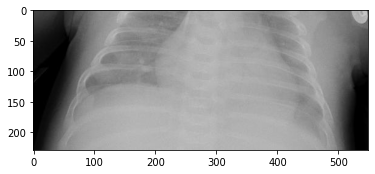

(229, 549, 3)


In [19]:
import matplotlib.pyplot as plt
im = io.imread(discarded[35])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

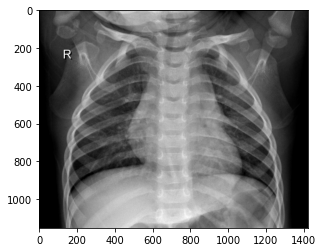

(1152, 1422)


In [20]:
im = io.imread(temp_train_images[1])
imgplot = plt.imshow(im, cmap="gray")
plt.show()
print(im.shape)

#### 4. Redistribute data to a train/validation/test split of 85/15/15

Now that the outliers have been removed, we can redistribute the data set to add some more images to the test set to bring the value up to 15%, and then split the remaining test set into a test and validation split of 85/15.

We won't touch the images in the test set, rather we will simply move some of the ones from the train set into the test set.

Using 15% instead of 20% because we son't have that many images to work with.

In [21]:
# new ratios after removing some outliers

total = len(temp_train_images) + len(temp_test_images)
print('total images = ', total)

percent_test = len(temp_test_images)/total
print('percent test ', percent_test*100)

percent_train = len(temp_train_images)/total
print('percent train ', percent_train*100)

total images =  5730
percent test  10.715532286212914
percent train  89.28446771378708


In [22]:
# calculate number of images to move from train set to test set

needed = 0.15*total
print(needed)

have = len(temp_test_images)
print(have)

difference = needed - have
print("need to add an additional ", difference, " images")

859.5
614
need to add an additional  245.5  images


In [23]:
# convert to pandas dataframe

# train set
data_train = {'file':temp_train_images,'label':temp_train_labels}
train_df = pd.DataFrame(data_train)

# test set
data_test = {'file':temp_test_images,'label':temp_test_labels}
test_df = pd.DataFrame(data_test)

In [24]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
5111,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5112,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5113,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
5114,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [25]:
train_df['file'][2000], train_df['label'][2000]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\train\\PNEUMONIA\\person1326_bacteria_3372.jpeg',
 'PNEUMONIA')

In [26]:
test_df['file'][200], test_df['label'][200]

('E:\\COURSES\\Advanced Data Science With IBM\\Advanced Data Science Capstone\\assignment\\data\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0340-0001.jpeg',
 'NORMAL')

In [27]:
# first shuffle rows in train dataframe
train_df = train_df.sample(n = len(train_df)).reset_index(drop=True)

In [28]:
# then move 245 rows from train dataframe to test dataframe
transferdata_df = train_df.iloc[-245:, 0:]

test_df = test_df.append(transferdata_df)

train_df = train_df.drop(transferdata_df.index)

In [29]:
# reset index of test_df
test_df = test_df.reset_index(drop=True)

In [30]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
4866,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4867,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4868,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4869,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL


In [31]:
test_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
4,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
...,...,...
854,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
855,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
856,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
857,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [32]:
# split train set further into train and validation set

newtrain_df = train_df.sample(frac=0.85,random_state=200) #random state is a seed value
validation_df = train_df.drop(newtrain_df.index)

In [33]:
train_df = newtrain_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [34]:
train_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
1,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
2,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
4135,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4136,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4137,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4138,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


In [35]:
validation_df

,file,label
0,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
1,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
2,E:\COURSES\Advanced Data Science With IBM\Adva...,NORMAL
3,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
4,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
...,...,...
726,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
727,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
728,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA
729,E:\COURSES\Advanced Data Science With IBM\Adva...,PNEUMONIA


We now have three data sets
- train_df (training set)
- validation_df (validation set)

- test_df (final test set)

#### 5. Shape and color of images

In [36]:
# Retrieving the geometry of the image and the number of pixels
# Images in scikit-image are represented by NumPy ndarrays. 
# Hence, many common operations can be achieved using standard NumPy methods for manipulating arrays

x = []
y = []
z = []
listofdataframes = [train_df, validation_df, test_df]

for df in listofdataframes:
    for index, row in df.iterrows():
        image = row['file']
        s = io.imread(image)
        x.append(s.shape[0])
        y.append(s.shape[1])
        if(len(s.shape) == 3):
            z.append(1)
        else:
            z.append(0)

In [37]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'x': x,
                   'y': y,
                   'z': z})

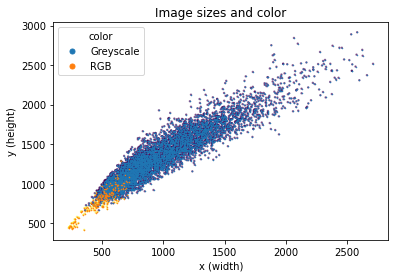

In [38]:
area = 2
plt.scatter(x, y, c=df.z, s=area,  alpha=0.5)
plt.title('Image sizes and color')
plt.xlabel('x (width)')
plt.ylabel('y (height)')
classes = [ 'Greyscale', 'RGB']
groups = df.groupby('z')
for name, group in groups:
    name = classes[0] if name == 0 else classes[1]
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=1, label=name)

plt.legend(title="color", markerscale=10)

plt.show()

 Since all the images are of different sizes, it will be necessary to reshape them to the same size.
 Also some are greyscale while other are RGB, so it will be necessary to normalize all images to the same color space (greyscale) 

## Data Preprocessing

The following steps need to be done in the data preprocessing step

#### Data Normalization Step

We perform a grayscale normalization to reduce the effect of illumination's differences.
Divide values by 255 to get a value between 0 and 1. 

#### Image Resize
images need to be resized to the same size - both training and test set

NOTE: this step will be done within train_datagen.flow_from_dataframe function by setting parameter 'target_size'

This is an example using skimage (we are not using this here)

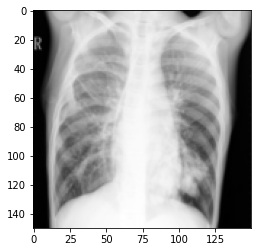

(150, 150)


In [39]:
from skimage.transform import resize
img = io.imread(train_df['file'][0])
img_rescaled = resize(img, (150,150))

imgplot = plt.imshow(img_rescaled, cmap="gray")
plt.show()
print(img_rescaled.shape)

### Image Augmentation Step

In order to avoid overfitting problem, alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [40]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [41]:
from keras.preprocessing.image import ImageDataGenerator

#### 1. Preprocessing the Training Set

Transformation on the images of the training set to avoid overfitting (data augmentation - see above)

In [42]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.05,
        horizontal_flip=True,
        width_shift_range=0.05,
        height_shift_range=0.05)

In [43]:
train_set = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 4140 validated image filenames belonging to 2 classes.


#### 2. Preprocesing the validation and test set

Here we need to keep the images as they were with no modifications but we have to feature scale the images to match the feature scaling done to the test images.

In [44]:
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [45]:
validation_datagen = ImageDataGenerator(
        rescale=1./255
        )

In [46]:
validation_set = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 731 validated image filenames belonging to 2 classes.


In [47]:
test_set = test_datagen.flow_from_dataframe(
    test_df,
    directory=None,
    x_col="file",
    y_col="label",
    weight_col=None,
    target_size=(128, 128),
    color_mode="grayscale",
    classes=None,
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
)

Found 859 validated image filenames belonging to 2 classes.


### Building the CNN

#### 1. Convolution

In [48]:
cnn = tf.keras.models.Sequential()

In [49]:
cnn.add(tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=3,
                               activation='relu',
                               input_shape=(128,128,1)
                              ))

#### 2. Pooling

In [50]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#### Add a second Convolutional Layer

In [51]:
cnn.add(tf.keras.layers.Conv2D(filters=32, 
                               kernel_size=3,
                               activation='relu'
                              ))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

#### 3. Flattening

In [52]:
cnn.add(tf.keras.layers.Flatten())

#### 4. Full Connection

In [53]:
#units = number of hidden neurons - larger number better for images
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

#### 5. Output Layer

In [54]:
#units = 1 for binary classification
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Training The CNN

#### 1. Calculate class weights

We will use the class_weights to correct for class imbalance to avoid a bias towards the majority class.

Formula to calculate the weight for a class

wj=n_samples / (n_classes * n_samplesj)

In [55]:
pneumonia_df = train_df.loc[train_df['label'] == 'PNEUMONIA']
print(pneumonia_df)

                                                   file      label
0     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
1     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
2     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
3     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4     E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
...                                                 ...        ...
4135  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4136  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4137  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4138  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA
4139  E:\COURSES\Advanced Data Science With IBM\Adva...  PNEUMONIA

[3059 rows x 2 columns]


In [56]:
normal_df = train_df.loc[train_df['label'] == 'NORMAL']
print(normal_df)

                                                   file   label
12    E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
15    E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
17    E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
18    E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
20    E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
...                                                 ...     ...
4114  E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
4119  E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
4120  E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
4126  E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL
4127  E:\COURSES\Advanced Data Science With IBM\Adva...  NORMAL

[1081 rows x 2 columns]


In [57]:
n_samples = len(train_df)
n_classes = 2
n_pneumonia = len(pneumonia_df)
n_normal = len(normal_df)

w_pneumonia = n_samples/(n_classes*n_pneumonia)
w_normal = n_samples/(n_classes*n_normal)

print("weights: pneumonia = ", w_pneumonia, ", normal = ", w_normal)

weights: pneumonia =  0.6766917293233082 , normal =  1.9148936170212767


In [58]:
# get the class indices

train_set.class_indices


{'NORMAL': 0, 'PNEUMONIA': 1}

In [59]:
# assign the class weights calculated above
# we will use this in the fit() method below

class_weight = {0: w_normal, 1: w_pneumonia}


#### 2. Compiling the CNN

In [60]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

In [61]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

#### 3. Training the CNN

In [62]:
# NOTE - cannot use the validation_split when using data set generators so need to split the dataframe manually
# into train and validation set. This was done above

history = cnn.fit(x = train_set, class_weight=class_weight, validation_data = validation_set, epochs=50 )


Epoch 1/50
130/130 [==============================] - 22s 169ms/step - loss: 0.4815 - accuracy: 0.7411 - precision: 0.9269 - recall: 0.7051 - val_loss: 0.2164 - val_accuracy: 0.9179 - val_precision: 0.9916 - val_recall: 0.8943
Epoch 2/50
130/130 [==============================] - 22s 167ms/step - loss: 0.2159 - accuracy: 0.9145 - precision: 0.9685 - recall: 0.9140 - val_loss: 0.1290 - val_accuracy: 0.9562 - val_precision: 0.9940 - val_recall: 0.9453
Epoch 3/50
130/130 [==============================] - 22s 167ms/step - loss: 0.1813 - accuracy: 0.9256 - precision: 0.9741 - recall: 0.9238 - val_loss: 0.1087 - val_accuracy: 0.9644 - val_precision: 0.9903 - val_recall: 0.9604
Epoch 4/50
130/130 [==============================] - 22s 168ms/step - loss: 0.1882 - accuracy: 0.9232 - precision: 0.9737 - recall: 0.9209 - val_loss: 0.0966 - val_accuracy: 0.9672 - val_precision: 0.9865 - val_recall: 0.9679
Epoch 5/50
130/130 [==============================] - 22s 168ms/step - loss: 0.1658 - accura

Epoch 37/50
130/130 [==============================] - 22s 167ms/step - loss: 0.0790 - accuracy: 0.9693 - precision: 0.9913 - recall: 0.9670 - val_loss: 0.0956 - val_accuracy: 0.9699 - val_precision: 0.9961 - val_recall: 0.9623
Epoch 38/50
130/130 [==============================] - 22s 167ms/step - loss: 0.0732 - accuracy: 0.9713 - precision: 0.9926 - recall: 0.9683 - val_loss: 0.0600 - val_accuracy: 0.9767 - val_precision: 0.9904 - val_recall: 0.9774
Epoch 39/50
130/130 [==============================] - 22s 168ms/step - loss: 0.0779 - accuracy: 0.9698 - precision: 0.9910 - recall: 0.9680 - val_loss: 0.0897 - val_accuracy: 0.9726 - val_precision: 1.0000 - val_recall: 0.9623
Epoch 40/50
130/130 [==============================] - 22s 169ms/step - loss: 0.0794 - accuracy: 0.9684 - precision: 0.9913 - recall: 0.9657 - val_loss: 0.0662 - val_accuracy: 0.9767 - val_precision: 0.9981 - val_recall: 0.9698
Epoch 41/50
130/130 [==============================] - 22s 168ms/step - loss: 0.0708 - a

### Evaluating

#### 1. Examine the training loss curves

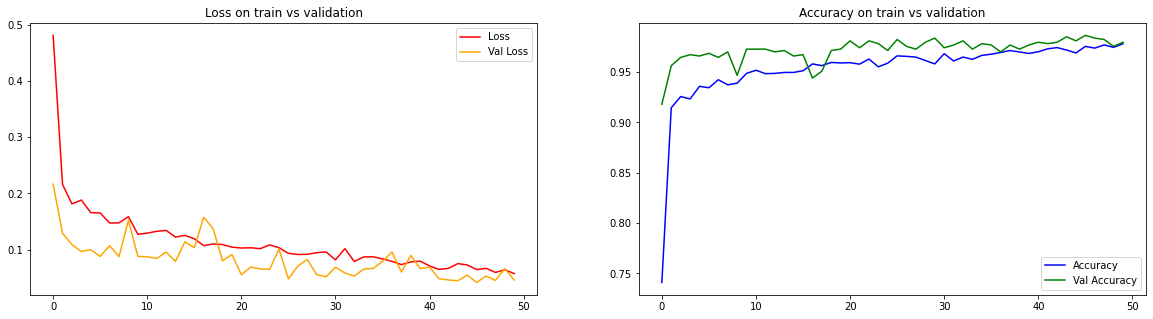

In [63]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

#### 2. Evaluate performance of the model on the test set